# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [54]:
import nltk.corpus
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [55]:
data = pd.read_csv('train.csv')

In [56]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [57]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [58]:
# -- YOUR CODE HERE --
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [59]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

В столбцах `keyword` и `location` выборки данных присутствуют пропуски. Заполняем их пустыми строками.

In [60]:
train = train[train.columns].fillna("")
test = test[test.columns].fillna("")

In [61]:
train.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [62]:
test.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Теперь пропусков нет!

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [63]:
# -- YOUR CODE HERE --
train["target"].value_counts()

0    3024
1    2305
Name: target, dtype: int64

Классы не сбалансированы. Число объектов отрицательного класса превосходит число объектов, принадлежащих положительному классу.

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [64]:
popular_keywords = list(train['keyword'].value_counts().drop('').sort_values(ascending=False)[:10].index)
popular_keywords

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'fatality',
 'harm',
 'twister',
 'nuclear%20reactor',
 'emergency']

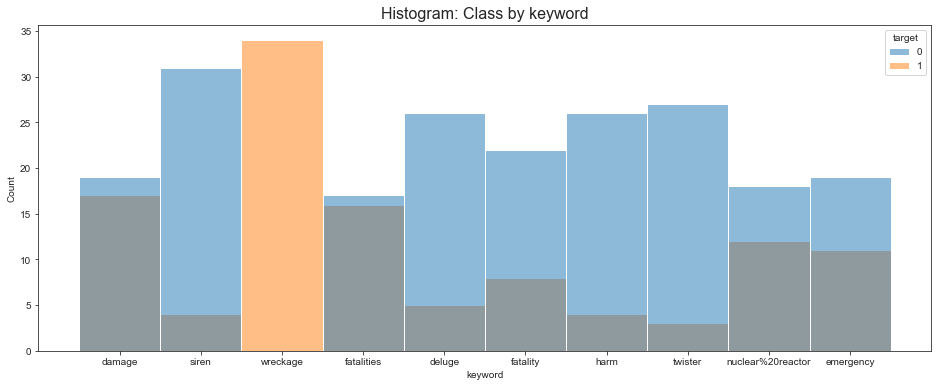

In [65]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.title('Histogram: Class by keyword', fontsize=16)
sns.set_style(style="ticks")
# Строим график
sns.histplot(train[train['keyword'].isin(popular_keywords)].sort_values(by="keyword", key=lambda x: x.map(dict(zip(popular_keywords, list(range(10)))))), x='keyword', hue='target', multiple="layer", ax=ax);

#### Выводы:
1. Число объектов положительного класса наибольшее среди объектов с ключевым словом `wreckage`;
2.  Число объектов отрицательного класса наибольшее среди объектов с ключевым словом `siren` (на втором месте `twister`, затем `harm` и `deluge`);
3. Все посты из твиттера, содержащие ключевое слово `wreckage`, относятся к положительному классу, то есть если твит содержит данное ключевое слово, то он однозначно содержит информацию о реальной катастрофе;
4. Для остальных 9 ключевых слов, число объектов отрицательного класса превосходит число объектов положительного;
5. Посты, содержащие ключевые слова `damage` и `fatalities` могут примерно с одинаковой вероятностью принадлежать как к положительному, так и к отрицательному классу, поэтому вне контекста они будут бесполезны для классификации;
6. Для ключевых слов `nuclear%20reactor` и `emergency` соотношение отрицательного класса к положительному примерно 3 к 2, однако так как отношение классов во всей выборке также приблизительно 3/2, то возможно это соотношение связано с дисбалансом классов и, следовательно, не дает информации, полезной для классификации);
7. Твиты с ключевыми словами `siren`, `twister`, `harm`, `deluge` и `fatality` с большой вероятностью относятся к отрицательному классу и могут играть важную роль в классификации.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [66]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [67]:
def concatenate_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.assign(text = (df["keyword"] + " " + df["location"] + " " + df["text"]))
    df_new = df_new.drop(['keyword', 'location'], axis=1)
    df_new = df_new.drop('id', axis=1)
    return df_new

In [68]:
train_new = concatenate_columns(train)

In [69]:
test_new = concatenate_columns(test)

In [70]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [71]:
from sklearn.feature_extraction.text import CountVectorizer

In [72]:
text_train = train_new["text"]

In [73]:
vectorizer = CountVectorizer()
train_vec = vectorizer.fit_transform(text_train)

In [74]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., 'ûóher', 'ûókody', 'ûótech'],
      dtype=object)

In [75]:
# Выведем размеры полученной матрицы
print("Matrix shape ", train_vec.toarray().shape)

Matrix shape  (5329, 18455)


Получилась матрица размерами (5329, 18455), где 5329 - число объектов тренировочной выборки, а 18455 - количество слов-признаков, найденных `CountVectorizer`.

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [76]:
import re

In [77]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    # -- YOUR CODE HERE --
    return any(c.isdigit() for c in s)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    # -- YOUR CODE HERE --
    return any(c in list(punctuation) for c in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # -- YOUR CODE HERE --
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    # -- YOUR CODE HERE --
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', # -- YOUR CODE HERE --
          sum(map(lambda x : contains_digit(x), vocabulary)))
    print('With punctuation:', # -- YOUR CODE HERE --
          sum(map(lambda x : contains_punctuation(x), vocabulary)))
    print('Hashtags:        ', # -- YOUR CODE HERE --
          sum(map(lambda x : is_hashtag(x), vocabulary)))
    print('Mentions:        ', # -- YOUR CODE HERE --
          sum(map(lambda x : is_mention(x), vocabulary)))




In [78]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [79]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


В словаре нашлось:
* 3812 слов, содержащих цифры;
* 315 слов, которые содержат символы пунктуации;
* 0 хэштегов и 0 упоминаний, так как регулярное выражение-токенайзер по умолчанию в CountVectorizer удаляет такие специальные символы, как '@' и '#'.

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [80]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

Используем TweetTokenizer по умолчанию.

In [81]:
tweet_tokenizer = TweetTokenizer()
tweet_vectorizer = CountVectorizer(tokenizer=tweet_tokenizer.tokenize)
train_tweet_vec = tweet_vectorizer.fit_transform(text_train)

In [82]:
print("Matrix shape ", train_tweet_vec.shape)

Matrix shape  (5329, 19670)


In [83]:
investigate_vocabulary(tweet_vectorizer.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


В нашем словаре стало:
* 3939 слов, содержащих цифры;
* 7338 слов, которые содержат символы пунктуации;
* 1470 хэштегов;
* 1679 упоминаний.

При этом размеры матрицы (количество слов в словаре) увеличились за счет слов со специальными символами.


Теперь попробуем использовать TweetTokenizer c надстройками:
* strip_handles - удаляет упоминания имен пользователей, написавших пост;
* reduce_len - заменяет повторяющиеся последовательности символов длины больше трех, на последовательности в 3 символа;
* preserve_case - установленный на False не сохраняет регистр букв при токенизации.

In [84]:
tokenizer_modified = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
tweet_vectorizer = CountVectorizer(tokenizer=tokenizer_modified.tokenize)
train_tweet_vec_mod = tweet_vectorizer.fit_transform(text_train)

In [85]:
print("Matrix shape ", train_tweet_vec_mod.shape)

Matrix shape  (5329, 17989)


In [86]:
investigate_vocabulary(tweet_vectorizer.vocabulary_)

With digit:       3645
With punctuation: 5669
Hashtags:         1470
Mentions:         10


В нашем словаре стало:
* 3645 слов, содержащих цифры;
* 5669 слов, которые содержат символы пунктуации;
* 1470 хэштегов;
* 10 упоминаний.

TweetTokenizer с надстройками, удаляющими имена пользователей, меняющими регистр и сокращающими длинные последовательности позволил уменьшить размеры матрицы (в основном за счет удаления упоминаний из словаря).

#### Сравнение:
* По сравнению с токенайзером по умолчанию из СoutVectorizer, при применении TweetTokenizer количество слов, содержащих цифры увеличилось незначительно, количество слов со знаками пунктуации увеличилось в 23 раза, а количество хэштегов и упоминаний увеличилось от нуля до полутора тысяч. При этом словарь увеличился примерно на 1000 слов. Это связано с тем, что регулярное выражение-токенайзер по умолчанию в CountVectorizer удаляет специальные символы, включая ‘@’ и ‘#’, тогда как TweetTokenizer включает слова в словарь вместе с ними.
* TweetTokenizer, не включающий в словарь упоминания авторов, позволил уменьшить размеры словаря на 1500 слов по сравнению с обычным TweetTokenizer, при этом сохранив хэштеги.

##### Вывод:
В отличие от токенизатора по умолчанию из CountVectorizer, TweetTokenizer сохраняет и позволяет отдельно обрабатывать слова с такими специальными символами, как ‘@’ и ‘#’, что, однако, увеличивает размеры словаря. Такой подход позволяет обращать внимание на хэштеги, которые могут нести ключевую информацию. При этом TweetTokenizer предоставляет возможность удалять из словаря лишние упоминания, которые, как правило, не несут важной информации.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [87]:
import nltk

In [88]:
nltk.download("stopwords", quiet=True)

True

In [89]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [90]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    # -- YOUR CODE HERE --
    return not bool(re.search(r"[^a-zA-Z]", s))

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    # -- YOUR CODE HERE --
    punctuation_symbols = list(punctuation)
    return bool(re.search(r"[()]", s)) and all(c in punctuation_symbols for c in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # -- YOUR CODE HERE --
    return s.startswith('#') and contains_only_latin_letters(s[1:])

def is_suitable(s: str) -> bool:
    # Проверка, что слово подходит под требования
    stop_list = set(stopwords.words("english"))
    if s in stop_list:
        return False
    if is_emoji(s):
        return True
    if is_hashtag(s):
        return True
    return contains_only_latin_letters(s)


def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    # -- YOUR CODE HERE --
    lowered = s.lower()
    tokenizer = TweetTokenizer()
    stemmer = SnowballStemmer("english")
    return [stemmer.stem(w) for w in tokenizer.tokenize(lowered) if is_suitable(w)]


In [91]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [92]:
# -- YOUR CODE HERE --
for i, text in enumerate(text_train.head(10)):
    print(f"---------------------Text #{i}---------------------")
    print(text)
    print("---------------------Result---------------------")
    print(custom_tokenizer(text))
    print()

---------------------Text #0---------------------
bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
---------------------Result---------------------
['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']

---------------------Text #1---------------------
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
---------------------Result---------------------
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']

---------------------Text #2---------------------
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
---------------------Result---------------------
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'the

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [93]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

In [94]:
text_test = test_new["text"]

In [95]:
bow_train = vectorizer.fit_transform(text_train)

In [96]:
bow_test = vectorizer.transform(text_test)

In [97]:
print("Matrix shape: ", bow_train.shape)

Matrix shape:  (5329, 10482)


В результате обработки текстов кастомным токенайзером количество слов в словаре уменьшилось более чем в 1.5 раза.

2. Обучите LogisticRegression на полученных признаках.


In [98]:
from sklearn.linear_model import LogisticRegression
# -- YOUR CODE HERE --
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report

In [99]:
y_train = train_new["target"]
y_test = test_new["target"]

In [100]:
scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

In [101]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(bow_train, y_train)
pred_bow = clf.predict(bow_test)

In [102]:
print(classification_report(y_test, pred_bow))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284



3. Посчитайте метрику f1-score на тестовых данных.

In [103]:
from sklearn.metrics import f1_score
# -- YOUR CODE HERE --
print(f"F1 score: {f1_score(y_test, pred_bow):.3f}")

F1 score: 0.744


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1

In [105]:
vec = TfidfVectorizer(tokenizer=custom_tokenizer)
vec_train = vec.fit_transform(text_train)
vec_test = vec.transform(text_test)

In [106]:
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

In [107]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

In [108]:
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1318
           1       0.79      0.71      0.75       966

    accuracy                           0.80      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.79      0.80      0.79      2284



In [109]:
print("Matrix shape: ", vec_train.shape)

Matrix shape:  (5329, 10482)


In [110]:
print(f"F1 score: {f1_score(y_test, pred_tfidf):.3f}")

F1 score: 0.746


1. **Ответ:**
    Судя по увеличению F1-score на 0.002, качество модели немного увеличилось.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [111]:
# 2
# -- YOUR CODE HERE --

In [112]:
vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
vec_train = vec.fit_transform(text_train)
vec_test = vec.transform(text_test)

In [113]:
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

In [114]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

In [115]:
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1318
           1       0.79      0.71      0.75       966

    accuracy                           0.80      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.79      0.80      0.79      2284



In [116]:
print("Matrix shape: ", vec_train.shape)

Matrix shape:  (5329, 10482)


In [117]:
# -- YOUR CODE HERE --
print(f"F1 score: {f1_score(y_test, pred_tfidf):.3f}")

F1 score: 0.746


2. **Ответ:**
   * Размеры матрицы не изменились, так как в текстах нет слов с частотой более 90%;
   * Так как словарь получился таким же, как в предыдущем пункте, то и качество модели не изменилось.


3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [118]:
# 3
# -- YOUR CODE HERE --

In [119]:
vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=2)
vec_train = vec.fit_transform(text_train)
vec_test = vec.transform(text_test)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

In [120]:
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1318
           1       0.79      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [121]:
print("Matrix shape: ", vec_train.shape)
print(f"F1 score: {f1_score(y_test, clf.predict(vec_test)):.3f}")

Matrix shape:  (5329, 4523)
F1 score: 0.752


3. **Ответ:**
  * Удаление слов, встречающихся в выборке менее двух раз, позволило уменьшить количество слов в словаре примерно в 2 раза и при этом увеличить качество модели (F1-score увеличился на 0.006, достигнув 0.752).

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [122]:
from sklearn.feature_extraction.text import HashingVectorizer

In [123]:
hash_vec = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
hv_train = hash_vec.fit_transform(text_train)
hv_test = hash_vec.transform(text_test)

scaler = MaxAbsScaler()
hv_train = scaler.fit_transform(hv_train)
hv_test = scaler.transform(hv_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(hv_train, y_train)
pred_hv = clf.predict(hv_test)

C:\Users\ageev\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [124]:
print(classification_report(y_test, pred_hv))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1318
           1       0.77      0.70      0.73       966

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.78      2284
weighted avg       0.78      0.78      0.78      2284



In [125]:
print("Matrix shape: ", hv_train.shape)
print(f"F1 score: {f1_score(y_test, clf.predict(hv_test)):.3f}")

Matrix shape:  (5329, 5000)
F1 score: 0.733


HashingVectorizer имеет наименьший F1-score из всех примененных подходов.

2. Какой из подходов показал самый высокий результат?

2. **Ответ:**
    Наилучший результат показал подход, использующий TfidfVectorizer с ограничением на минимальное количество вхождений слова в выборку. Этот способ позволил достичь F1-score равный 0.752 на тестовых данных.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [126]:
# -- YOUR CODE HERE --
bow_vec = CountVectorizer()
bow_train = bow_vec.fit_transform(text_train)
bow_test = bow_vec.transform(text_test)

scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(bow_train, y_train)
pred_bow = clf.predict(bow_test)

In [127]:
print(classification_report(y_test, pred_bow))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1318
           1       0.81      0.71      0.76       966

    accuracy                           0.81      2284
   macro avg       0.81      0.80      0.80      2284
weighted avg       0.81      0.81      0.81      2284



In [128]:
print("Matrix shape: ", bow_train.shape)

Matrix shape:  (5329, 18455)


In [129]:
print(f"F1 score: {f1_score(y_test, clf.predict(bow_test)):.3f}")

F1 score: 0.758


#### Итог:
Лучшего результата с F1-score рвным 0.758 удалось достичь с помощью CountVectorizer c токенизатором по умолчанию.
Удивительно, но самая простая из моделей оказалась в данном случае самой эффективной.